## Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from binance.client import Client
from datetime import datetime

## Initialise API

In [2]:
API_KEY = 'JPFZLK0ZgvhSniD3fvCNDQSC8UFin0kLKeIOJToe9LyGaJhQG29ZVWqTuZ792jAV'
API_SECRET = 'jw1UUQ4r5xFUgZHSiZcS8hssAKqwDYr8QzehZiNTRnXZBRWvpNQ9mtRyGcS4vfja'

client = Client(API_KEY, API_SECRET)

## Define Wallet Class

In [3]:
class Wallet:
    def __init__(self, initial_balance):
        self.balance = initial_balance
        self.coins = {}

    def add_coin(self, name, quantity, value):
        cost = quantity * value
        # Check if have enough money
        if self.balance > cost:
            self.balance -= cost
            if name in self.coins:
                self.coins[name] += quantity
            else:
                self.coins[name] = quantity
            return True
        else:
            return False

    def remove_coin(self, name, quantity, value):
        if name in self.coins:
            if self.coins[name] >= quantity:
                cost = quantity * value
                self.balance += cost
                self.coins[name] -= quantity
                if self.coins[name] == 0:
                    del self.coins[name]
                return True
            else:
                return False
        else:
            return False

    def get_coin_quantity(self, name):
        if name in self.coins:
            return self.coins[name]
        else:
            return 0

    def get_balance(self):
        return self.balance
    
    def get_coins(self):
        return self.coins

## Define Strategy

In [4]:
class Strategy:
    def __init__(self, window_size):
        self.window_size = window_size
        self.price_history = []

    def update_price_history(self, price):
        self.price_history.append(price)
        if len(self.price_history) > self.window_size:
            self.price_history.pop(0)

    def generate_signals(self, observed_price):
        if len(self.price_history) < self.window_size:
            return 'HOLD'
        average_price = sum(self.price_history) / self.window_size
        if observed_price > average_price:
            return 'BUY'
        else:
            return 'SELL'

## Backtesting Strategy

### Parameters

In [5]:
symbol = 'BTCUSDT'
coin_name = 'BTC'
initial_balance = 100000

In [6]:
interval = Client.KLINE_INTERVAL_1DAY  # Replace with the desired interval (e.g., KLINE_INTERVAL_1MINUTE, KLINE_INTERVAL_1HOUR)
start_time_train = int(datetime(2020,1,1,0,0).timestamp() * 1000)
end_time_train = int(datetime(2022,1,1,0,0).timestamp() * 1000)
start_time_val = int(datetime(2022,1,1,0,0).timestamp() * 1000)
end_time_val = int(datetime(2024,1,1,0,0).timestamp() * 1000)

### Fetch Data

In [7]:
# klines = client.get_historical_klines(symbol=symbol, interval=interval, start_str=start_time_train, end_str=end_time_train)
# # Extract close prices and timestamps from kline data
# close_prices = [float(kline[4]) for kline in klines]
# timestamps = [datetime.fromtimestamp(kline[0] / 1000) for kline in klines]

# # Create a DataFrame from the extracted data
# data = pd.DataFrame({'Timestamp': timestamps, 'Close Price': close_prices})

In [8]:
def fetchData(client, symbol, interval, start_time, end_time):
    klines = client.get_historical_klines(symbol=symbol, interval=interval, start_str=start_time, end_str=end_time)
    close_prices = [float(kline[4]) for kline in klines]
    timestamps = [datetime.fromtimestamp(kline[0] / 1000) for kline in klines]

    data = pd.DataFrame({'Timestamp': timestamps, 'Close Price': close_prices})

    return data

### Initialise Objects

In [9]:
# wallet = Wallet(initial_balance=initial_balance)
# strategy = Strategy(window_size=window_size)

### Simulating

In [10]:
def simulation(data, wallet, strategy):
    data_balance = [None] * len(data)
    data_signal = [None] * len(data)
    for row in data.itertuples():
        data_index = row[0]
        close_price = row[2]

        strategy.update_price_history(close_price)
        signal = strategy.generate_signals(close_price)

        if signal == 'BUY':
            available_balance = wallet.get_balance()
            if available_balance > 1:
                quantity = available_balance / close_price
                if wallet.add_coin(coin_name, quantity, close_price):
                    data_signal[data_index] = 'BUY'

        elif signal == 'SELL':
            coin_pair = wallet.get_coins()
            if len(coin_pair) > 0:
                for coin_name_in_wallet, coin_qty_in_wallet in coin_pair.items():
                    if coin_name == coin_name_in_wallet:
                        if wallet.remove_coin(coin_name, coin_qty_in_wallet, close_price):
                            data_signal[data_index] = 'SELL'
                        break
        
        data_balance[data_index] = wallet.get_balance()

    # Force sell all coin
    coin_pair = wallet.get_coins()
    if len(coin_pair) > 0:
        for coin_name_in_wallet, coin_qty_in_wallet in coin_pair.items():
            if coin_name == coin_name_in_wallet:
                if wallet.remove_coin(coin_name, coin_qty_in_wallet, close_price):
                    data_signal[data_index] = 'SELL'
                break

    data_balance[data_index] = wallet.get_balance()

    data['Signal'] = data_signal
    data['Balance'] = data_balance
    return data

## Results

### Graph

In [11]:
# Plot the close prices


# plt.plot(data['Timestamp'], data['Close Price'],
#          linestyle='--', linewidth=1)
# plt.title('Close Prices')
# plt.xlabel('Timestamp')
# plt.ylabel('Close Price')

# plt.scatter(data.loc[data['Signal'] == 'BUY', 'Timestamp'].values,
#             data.loc[data['Signal'] == 'BUY', 'Close Price'].values,
#             marker='^',
#             color='green',
#             label='Buy Signals')

# plt.scatter(data.loc[data['Signal'] == 'SELL', 'Timestamp'].values,
#             data.loc[data['Signal'] == 'SELL', 'Close Price'].values,
#             marker='v',
#             color='red',
#             label='Sell Signals')

# plt.legend()
# plt.show()

### Optimizing

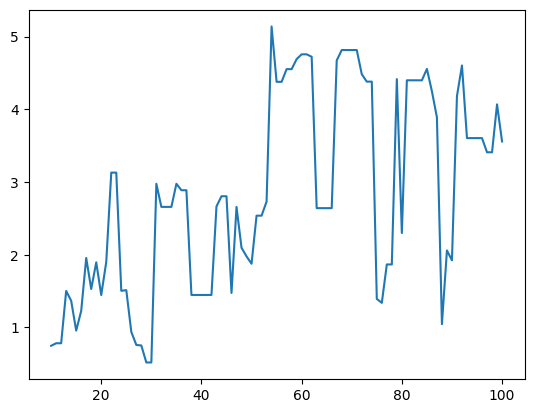

In [16]:
data_train = fetchData(client, symbol, interval, start_time_train, end_time_train)
data_val = fetchData(client, symbol, interval, start_time_val, end_time_val)

profits = []
for window_size in range(10,101):
    wallet = Wallet(initial_balance=initial_balance)
    strategy = Strategy(window_size=window_size)
    sim_data = simulation(data_train, wallet, strategy)
    ending_balance = sim_data['Balance'].iloc[-1]
    profits.append(ending_balance / initial_balance)

result_train = pd.DataFrame({'window_size': range(10, 101),
                       'profit': profits})

plt.plot(result_train['window_size'], result_train['profit'])

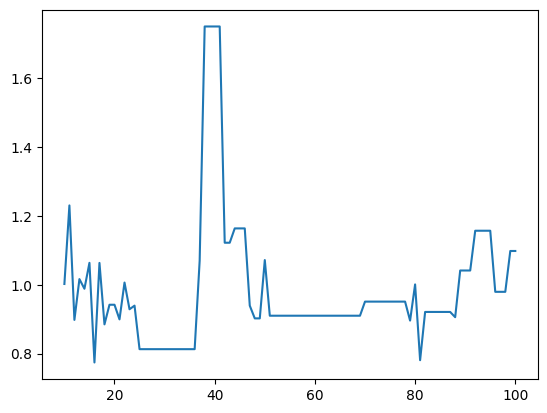

In [17]:
profits = []
for window_size in range(10,101):
    wallet = Wallet(initial_balance=initial_balance)
    strategy = Strategy(window_size=window_size)
    sim_data = simulation(data_val, wallet, strategy)
    ending_balance = sim_data['Balance'].iloc[-1]
    profits.append(ending_balance / initial_balance)

result_val = pd.DataFrame({'window_size': range(10, 101),
                           'profit': profits})
plt.plot(result_val['window_size'], result_val['profit'])

In [13]:
max_profit_row = result_train[result_train['profit'] == result_train['profit'].max()]
window_size_opt_train = int(max_profit_row['window_size'])

/var/folders/ft/h3fjv72s4jdftdb2szbgyggr0000gp/T/ipykernel_11531/2381185276.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  window_size_opt_train = int(max_profit_row['window_size'])


In [14]:
wallet = Wallet(initial_balance=initial_balance)
strategy = Strategy(window_size=window_size_opt_train)
sim_data = simulation(data_val, wallet, strategy)
ending_balance = sim_data['Balance'].iloc[-1]

In [15]:
print(ending_balance)

90992.84235632015
